# Project 3:  Implement SLAM 

---

## Project Overview

In this project, you'll implement SLAM for robot that moves and senses in a 2 dimensional, grid world!

SLAM gives us a way to both localize a robot and build up a map of its environment as a robot moves and senses in real-time. This is an active area of research in the fields of robotics and autonomous systems. Since this localization and map-building relies on the visual sensing of landmarks, this is a computer vision problem. 

Using what you've learned about robot motion, representations of uncertainty in motion and sensing, and localization techniques, you will be tasked with defining a function, `slam`, which takes in six parameters as input and returns the vector `mu`. 
> `mu` contains the (x,y) coordinate locations of the robot as it moves, and the positions of landmarks that it senses in the world

You can implement helper functions as you see fit, but your function must return `mu`. The vector, `mu`, should have (x, y) coordinates interlaced, for example, if there were 2 poses and 2 landmarks, `mu` will look like the following, where `P` is the robot position and `L` the landmark position:
```
mu =  matrix([[Px0],
              [Py0],
              [Px1],
              [Py1],
              [Lx0],
              [Ly0],
              [Lx1],
              [Ly1]])
```

You can see that `mu` holds the poses first `(x0, y0), (x1, y1), ...,` then the landmark locations at the end of the matrix; we consider a `nx1` matrix to be a vector.

## Generating an environment

In a real SLAM problem, you may be given a map that contains information about landmark locations, and in this example, we will make our own data using the `make_data` function, which generates a world grid with landmarks in it and then generates data by placing a robot in that world and moving and sensing over some numer of time steps. The `make_data` function relies on a correct implementation of robot move/sense functions, which, at this point, should be complete and in the `robot_class.py` file. The data is collected as an instantiated robot moves and senses in a world. Your SLAM function will take in this data as input. So, let's first create this data and explore how it represents the movement and sensor measurements that our robot takes.

---

In [1]:
# import data viz resources
import matplotlib.pyplot as plt
from pandas import DataFrame
import seaborn as sns
import numpy as np
from helpers import make_data
import ipywidgets as widgets
from IPython.display import display

## Create the world

Use the code below to generate a world of a specified size with randomly generated landmark locations. You can change these parameters and see how your implementation of SLAM responds! 

`data` holds the sensors measurements and motion of your robot over time. It stores the measurements as `data[i][0]` and the motion as `data[i][1]`.

#### Helper functions

You will be working with the `robot` class that may look familiar from the first notebook, 

In fact, in the `helpers.py` file, you can read the details of how data is made with the `make_data` function. It should look very similar to the robot move/sense cycle you've seen in the first notebook.

In [19]:
# I played around with these. They might not be the original values.

# world parameters
num_landmarks      = 5        # number of landmarks
N                  = 20       # time steps
world_size         = 100.0    # size of world (square)

# robot parameters
measurement_range  = 50.0     # range at which we can sense landmarks
motion_noise       = 1.       # noise in robot motion
measurement_noise  = 10.       # noise in the measurements
distance           = 20.0     # distance by which robot (intends to) move each iteratation 


# I modified this function so it returns the ground truth trajectory and landmarks.
data, ground_truth = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)

 
Landmarks:  [[12, 73], [84, 65], [3, 73], [77, 26], [72, 72]]
Robot: [x=48.35134 y=28.48021]


Initialization of the linear system
-----------------------------------------------

In [3]:
def initialize_constraints(N, num_landmarks, world_size):
    ''' This function takes in a number of time steps N, number of landmarks, and a world_size,
        and returns initialized constraint matrices, omega and xi.'''
    
    ## Recommended: Define and store the size (rows/cols) of the constraint matrix in a variable
    size = (N + num_landmarks)*2
    
    ## TODO: Define the constraint matrix, Omega, with two initial "strength" values
    ## for the initial x, y location of our robot
    
    # Does a strength value, I mean coefficient different from 1, really have a meaning here?
    # I imagine the trajectory has to be "anchored" somewhere. Which will be the initial position.
    # Whatever else we have in the system should not should not affect the initial position.
    # The magnitude of the other coefficient would only affect the positions of the other points
    # relative to the initial position, right?
    
    omega = np.matrix(np.zeros((size,size)))
    omega[0,0] = 1.
    omega[1,1] = 1.
    
    ## TODO: Define the constraint *vector*, xi
    ## you can assume that the robot starts out in the middle of the world with 100% confidence
    xi = np.zeros((size,))
    xi[0] = world_size / 2.
    xi[1] = world_size / 2.
    
    return omega, xi

---
## SLAM inputs 

In addition to `data`, your slam function will also take in:
* N -   The number of time steps that a robot will be moving and sensing
* num_landmarks - The number of landmarks in the world
* world_size - The size (w/h) of your world
* motion_noise - The noise associated with motion; the update confidence for motion should be `1.0/motion_noise`
* measurement_noise - The noise associated with measurement/sensing; the update weight for measurement should be `1.0/measurement_noise`

#### A note on noise

Recall that `omega` holds the relative "strengths" or weights for each position variable, and you can update these weights by accessing the correct index in omega `omega[row][col]` and *adding/subtracting* `1.0/noise` where `noise` is measurement or motion noise. `Xi` holds actual position values, and so to update `xi` you'll do a similar addition process only using the actual value of a motion or measurement. So for a vector index `xi[row][0]` you will end up adding/subtracting one measurement or motion divided by their respective `noise`.

### TODO: Implement Graph SLAM

Follow the TODO's below to help you complete this slam implementation (these TODO's are in the recommended order), then test out your implementation! 

#### Updating with motion and measurements

With a 2D omega and xi structure as shown above (in earlier cells), you'll have to be mindful about how you update the values in these constraint matrices to account for motion and measurement constraints in the x and y directions. Recall that the solution to these matrices (which holds all values for robot poses `P` and landmark locations `L`) is the vector, `mu`, which can be computed at the end of the construction of omega and xi as the inverse of omega times xi: $\mu = \Omega^{-1}\xi$

**You may also choose to return the values of `omega` and `xi` if you want to visualize their final state!**

In [4]:
## TODO: Complete the code to implement SLAM

def add_constraint(omega, xi, i, j, dx, dy, strength):
    i2 = 2*i
    j2 = 2*j
    # mu_x[i] - mu_x[j] = dx
    omega[i2,i2] += strength
    omega[i2,j2] += -strength
    xi[i2] += dx*strength
    #  - mu_x[i] + mu_x[j] = -dx
    omega[j2,i2] += -strength
    omega[j2,j2] += strength
    xi[j2] += -dx*strength
    # mu_y[i] - mu_y[j] = dy
    omega[i2+1,i2+1] += strength
    omega[i2+1,j2+1] += -strength
    xi[i2+1] += dy*strength
    # - mu_y[i] + mu_y[j] = dy
    omega[j2+1 ,i2+1] += -strength
    omega[j2+1 ,j2+1] += strength
    xi[j2+1] += -dy*strength
    
## slam takes in 6 arguments and returns mu, 
## mu is the entire path traversed by a robot (all x,y poses) *and* all landmarks locations
def slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise):
    omega, xi = initialize_constraints(N, num_landmarks, world_size)
    
    for i, (measurements, motion) in enumerate(data):
        # Note: Mesurements are collected before the movement.
        #       So the last pose has no measurements to correct it (?)
        for L, mx, my in measurements:
            add_constraint(omega, xi, N+L, i, mx, my, 1./measurement_noise)
        add_constraint(omega, xi, i+1, i, motion[0], motion[1], 1./motion_noise)
    
#     plt.rcParams["figure.figsize"] = (10,7)
#     sns.heatmap(DataFrame(omega), cmap='Blues', annot=True, linewidths=.5)

    mu = np.linalg.solve(omega, xi)    
    return mu


In [5]:
# a helper function that creates a list of poses and of landmarks for ease of printing
# this only works for the suggested constraint architecture of interlaced x,y poses
def get_poses_landmarks(mu, N):
    # create a list of poses
    poses = []
    for i in range(N):
        poses.append((mu[2*i].item(), mu[2*i+1].item()))

    # create a list of landmarks
    landmarks = []
    for i in range(num_landmarks):
        landmarks.append((mu[2*(N+i)].item(), mu[2*(N+i)+1].item()))

    # return completed lists
    return poses, landmarks


In [6]:
def print_all(poses, landmarks):
    print('\n')
    print('Estimated Poses:')
    for i in range(len(poses)):
        print('['+', '.join('%.3f'%p for p in poses[i])+']')
    print('\n')
    print('Estimated Landmarks:')
    for i in range(len(landmarks)):
        print('['+', '.join('%.3f'%l for l in landmarks[i])+']')

## Run SLAM

Once you've completed your implementation of `slam`, see what `mu` it returns for different world sizes and different landmarks!

In [20]:
# call your implementation of slam, passing in the necessary parameters
mu = slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise)

example_poses, example_landmarks = get_poses_landmarks(mu, N)
print_all(example_poses, example_landmarks)



Estimated Poses:
[50.000, 50.000]
[41.358, 66.424]
[31.772, 84.383]
[50.717, 92.721]
[35.993, 81.076]
[19.669, 69.050]
[25.470, 48.774]
[30.858, 29.530]
[35.280, 10.611]
[48.620, 24.996]
[62.001, 38.454]
[75.049, 52.940]
[88.698, 67.609]
[73.281, 55.729]
[57.432, 43.060]
[43.427, 31.781]
[28.416, 19.624]
[12.957, 6.998]
[28.420, 19.743]
[43.983, 32.305]


Estimated Landmarks:
[15.217, 71.979]
[80.532, 63.860]
[3.366, 72.295]
[76.523, 26.651]
[71.724, 68.835]


## Visualize the constructed world

I wrote a function that plots both, the estimated robot locations as well as the ground truth.
It also displays the landmarks, both true and estimated, the "commanded" motion vectors, and the measurement vectors.

With the power of jupyter widgets you can set the time for which to highlight positions and display measurement data.

In [8]:
def display_world2(world_size, poses, landmarks,  data, ground_truth):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    slider = widgets.IntSlider(max = N-1, continuous_update=True, description='Time')
    
    true_landmarks, true_trajectory = ground_truth
    true_landmarks = np.array(true_landmarks)
    true_trajectory = np.array(true_trajectory)
    
    def update(*args):
        time = slider.value
        ax.clear()       
        ax.set(title = 't={}'.format(time))

        plt.plot(*true_trajectory.T, color='g', marker='o', ls=':', ms=3., label='x')
        plt.scatter(*true_landmarks.T, color='b', marker='*', s=40, label = 'L')
        
        plt.scatter(*np.asarray(poses).T, color='r', marker='o', s=4, label='x (estimated)')
        plt.scatter(*np.asarray(landmarks).T, color='m', marker='*', s=40, label='L (estimated)')
        
        if time < len(data):
            pose, (measurements, motion) = true_trajectory[time], data[time]
            for i, dx, dy in measurements:
                ax.arrow(pose[0], pose[1], dx, dy, label='measurement' if i==0 else None)
                ax.text(pose[0]+dx, pose[1]+dy, str(i), ha='center', va='center', color='b', fontsize=10)
            ax.arrow(pose[0], pose[1], motion[0], motion[1], color='r', width=0.2, label='motion')
        
        ax.scatter([poses[time][0]],[poses[time][1]], color='r', marker='o', s=40)
        ax.scatter(*true_trajectory[time:time+1].T, color='g', marker='o', s=40)
        
        ax.legend()
        ax.set(xlim=(0., world_size), ylim=(0., world_size))
        
        # Display final result
        plt.show()
        
    update(0)
    slider.observe(update)
    display(slider)

<IPython.core.display.Javascript object>


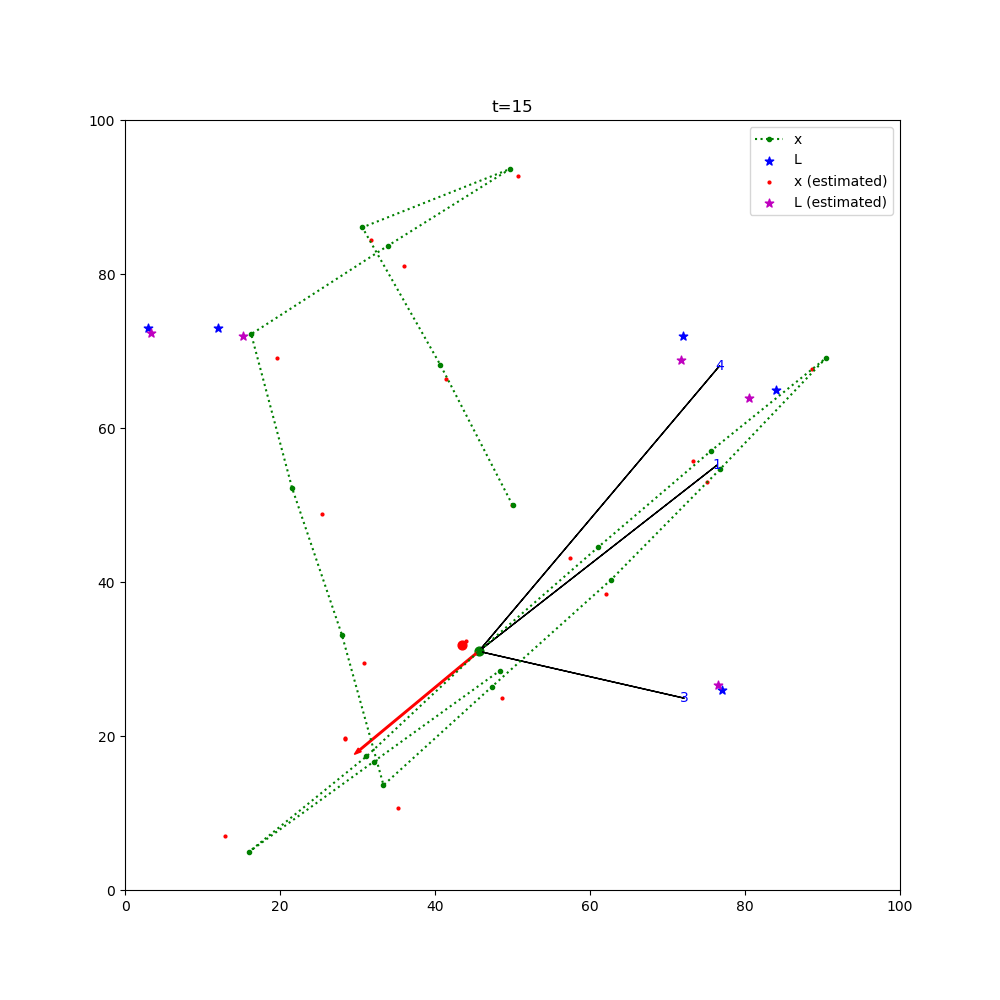

IntSlider(value=0, description='Time', max=19)

In [21]:
%matplotlib notebook
display_world2(int(world_size), example_poses, example_landmarks, data, ground_truth)

### Question: How far away is your final pose (as estimated by `slam`) compared to the *true* final pose? Why do you think these poses are different?

You can find the true value of the final pose in one of the first cells where `make_data` was called. You may also want to look at the true landmark locations and compare them to those that were estimated by `slam`. Ask yourself: what do you think would happen if we moved and sensed more (increased N)? Or if we had lower/higher noise parameters.

**Answer**: The difference in the pose is about 3 units. The estimate is different from the ground truth because of the measurement and movement noise. I think the algorithm should give more precise results the more often the same landmark is observed. Basically the noise should average out. Odometry or landmark measurements can compensate for high variance in the respective other measurement. At least for some time. Movement errors will accumulate. The error should grow faster the higher the variance of the motion vectors. Ultimately the pose error should be bounded by the landmark measurement error, if sufficent number of landmarks are observed.

## Testing

To confirm that your slam code works before submitting your project, it is suggested that you run it on some test data and cases. A few such cases have been provided for you, in the cells below. When you are ready, uncomment the test cases in the next cells (there are two test cases, total); your output should be **close-to or exactly** identical to the given results. If there are minor discrepancies it could be a matter of floating point accuracy or in the calculation of the inverse matrix.

### Submit your project

If you pass these tests, it is a good indication that your project will pass all the specifications in the project rubric. Follow the submission instructions to officially submit!

In [10]:
# Here is the data and estimated outputs for test case 1

test_data1 = [[[[1, 19.457599255548065, 23.8387362100849], [2, -13.195807561967236, 11.708840328458608], [3, -30.0954905279171, 15.387879242505843]], [-12.2607279422326, -15.801093326936487]], [[[2, -0.4659930049620491, 28.088559771215664], [4, -17.866382374890936, -16.384904503932]], [-12.2607279422326, -15.801093326936487]], [[[4, -6.202512900833806, -1.823403210274639]], [-12.2607279422326, -15.801093326936487]], [[[4, 7.412136480918645, 15.388585962142429]], [14.008259661173426, 14.274756084260822]], [[[4, -7.526138813444998, -0.4563942429717849]], [14.008259661173426, 14.274756084260822]], [[[2, -6.299793150150058, 29.047830407717623], [4, -21.93551130411791, -13.21956810989039]], [14.008259661173426, 14.274756084260822]], [[[1, 15.796300959032276, 30.65769689694247], [2, -18.64370821983482, 17.380022987031367]], [14.008259661173426, 14.274756084260822]], [[[1, 0.40311325410337906, 14.169429532679855], [2, -35.069349468466235, 2.4945558982439957]], [14.008259661173426, 14.274756084260822]], [[[1, -16.71340983241936, -2.777000269543834]], [-11.006096015782283, 16.699276945166858]], [[[1, -3.611096830835776, -17.954019226763958]], [-19.693482634035977, 3.488085684573048]], [[[1, 18.398273354362416, -22.705102332550947]], [-19.693482634035977, 3.488085684573048]], [[[2, 2.789312482883833, -39.73720193121324]], [12.849049222879723, -15.326510824972983]], [[[1, 21.26897046581808, -10.121029799040915], [2, -11.917698965880655, -23.17711662602097], [3, -31.81167947898398, -16.7985673023331]], [12.849049222879723, -15.326510824972983]], [[[1, 10.48157743234859, 5.692957082575485], [2, -22.31488473554935, -5.389184118551409], [3, -40.81803984305378, -2.4703329790238118]], [12.849049222879723, -15.326510824972983]], [[[0, 10.591050242096598, -39.2051798967113], [1, -3.5675572049297553, 22.849456408289125], [2, -38.39251065320351, 7.288990306029511]], [12.849049222879723, -15.326510824972983]], [[[0, -3.6225556479370766, -25.58006865235512]], [-7.8874682868419965, -18.379005523261092]], [[[0, 1.9784503557879374, -6.5025974151499]], [-7.8874682868419965, -18.379005523261092]], [[[0, 10.050665232782423, 11.026385307998742]], [-17.82919359778298, 9.062000642947142]], [[[0, 26.526838150174818, -0.22563393232425621], [4, -33.70303936886652, 2.880339841013677]], [-17.82919359778298, 9.062000642947142]]]

##  Test Case 1
##
# Estimated Pose(s):
#     [50.000, 50.000]
#     [37.858, 33.921]
#     [25.905, 18.268]
#     [13.524, 2.224]
#     [27.912, 16.886]
#     [42.250, 30.994]
#     [55.992, 44.886]
#     [70.749, 59.867]
#     [85.371, 75.230]
#     [73.831, 92.354]
#     [53.406, 96.465]
#     [34.370, 100.134]
#     [48.346, 83.952]
#     [60.494, 68.338]
#     [73.648, 53.082]
#     [86.733, 38.197]
#     [79.983, 20.324]
#     [72.515, 2.837]
#     [54.993, 13.221]
#     [37.164, 22.283]


# Estimated Landmarks:
#     [82.679, 13.435]
#     [70.417, 74.203]
#     [36.688, 61.431]
#     [18.705, 66.136]
#     [20.437, 16.983]


### Uncomment the following three lines for test case 1 and compare the output to the values above ###

mu_1 = slam(test_data1, 20, 5, 100.0, 2.0, 2.0)
poses, landmarks = get_poses_landmarks(mu_1, 20)
print_all(poses, landmarks)



Estimated Poses:
[50.000, 50.000]
[37.973, 33.652]
[26.185, 18.155]
[13.745, 2.116]
[28.097, 16.783]
[42.384, 30.902]
[55.831, 44.497]
[70.857, 59.699]
[85.697, 75.543]
[74.011, 92.434]
[53.544, 96.454]
[34.525, 100.080]
[48.623, 83.953]
[60.197, 68.107]
[73.778, 52.935]
[87.132, 38.538]
[80.303, 20.508]
[72.798, 2.945]
[55.245, 13.255]
[37.416, 22.317]


Estimated Landmarks:
[82.956, 13.539]
[70.495, 74.141]
[36.740, 61.281]
[18.698, 66.060]
[20.635, 16.875]


In [11]:
# Here is the data and estimated outputs for test case 2

test_data2 = [[[[0, 26.543274387283322, -6.262538160312672], [3, 9.937396825799755, -9.128540360867689]], [18.92765331253674, -6.460955043986683]], [[[0, 7.706544739722961, -3.758467215445748], [1, 17.03954411948937, 31.705489938553438], [3, -11.61731288777497, -6.64964096716416]], [18.92765331253674, -6.460955043986683]], [[[0, -12.35130507136378, 2.585119104239249], [1, -2.563534536165313, 38.22159657838369], [3, -26.961236804740935, -0.4802312626141525]], [-11.167066095509824, 16.592065417497455]], [[[0, 1.4138633151721272, -13.912454837810632], [1, 8.087721200818589, 20.51845934354381], [3, -17.091723454402302, -16.521500551709707], [4, -7.414211721400232, 38.09191602674439]], [-11.167066095509824, 16.592065417497455]], [[[0, 12.886743222179561, -28.703968411636318], [1, 21.660953298391387, 3.4912891084614914], [3, -6.401401414569506, -32.321583037341625], [4, 5.034079343639034, 23.102207946092893]], [-11.167066095509824, 16.592065417497455]], [[[1, 31.126317672358578, -10.036784369535214], [2, -38.70878528420893, 7.4987265861424595], [4, 17.977218575473767, 6.150889254289742]], [-6.595520680493778, -18.88118393939265]], [[[1, 41.82460922922086, 7.847527392202475], [3, 15.711709540417502, -30.34633659912818]], [-6.595520680493778, -18.88118393939265]], [[[0, 40.18454208294434, -6.710999804403755], [3, 23.019508919299156, -10.12110867290604]], [-6.595520680493778, -18.88118393939265]], [[[3, 27.18579315312821, 8.067219022708391]], [-6.595520680493778, -18.88118393939265]], [[], [11.492663265706092, 16.36822198838621]], [[[3, 24.57154567653098, 13.461499960708197]], [11.492663265706092, 16.36822198838621]], [[[0, 31.61945290413707, 0.4272295085799329], [3, 16.97392299158991, -5.274596836133088]], [11.492663265706092, 16.36822198838621]], [[[0, 22.407381798735177, -18.03500068379259], [1, 29.642444125196995, 17.3794951934614], [3, 4.7969752441371645, -21.07505361639969], [4, 14.726069092569372, 32.75999422300078]], [11.492663265706092, 16.36822198838621]], [[[0, 10.705527984670137, -34.589764174299596], [1, 18.58772336795603, -0.20109708164787765], [3, -4.839806195049413, -39.92208742305105], [4, 4.18824810165454, 14.146847823548889]], [11.492663265706092, 16.36822198838621]], [[[1, 5.878492140223764, -19.955352450942357], [4, -7.059505455306587, -0.9740849280550585]], [19.628527845173146, 3.83678180657467]], [[[1, -11.150789592446378, -22.736641053247872], [4, -28.832815721158255, -3.9462962046291388]], [-19.841703647091965, 2.5113335861604362]], [[[1, 8.64427397916182, -20.286336970889053], [4, -5.036917727942285, -6.311739993868336]], [-5.946642674882207, -19.09548221169787]], [[[0, 7.151866679283043, -39.56103232616369], [1, 16.01535401373368, -3.780995345194027], [4, -3.04801331832137, 13.697362774960865]], [-5.946642674882207, -19.09548221169787]], [[[0, 12.872879480504395, -19.707592098123207], [1, 22.236710716903136, 16.331770792606406], [3, -4.841206109583004, -21.24604435851242], [4, 4.27111163223552, 32.25309748614184]], [-5.946642674882207, -19.09548221169787]]] 


##  Test Case 2
##
# Estimated Pose(s):
#     [50.000, 50.000]
#     [69.035, 45.061]
#     [87.655, 38.971]
#     [76.084, 55.541]
#     [64.283, 71.684]
#     [52.396, 87.887]
#     [44.674, 68.948]
#     [37.532, 49.680]
#     [31.392, 30.893]
#     [24.796, 12.012]
#     [33.641, 26.440]
#     [43.858, 43.560]
#     [54.735, 60.659]
#     [65.884, 77.791]
#     [77.413, 94.554]
#     [96.740, 98.020]
#     [76.149, 99.586]
#     [70.211, 80.580]
#     [64.130, 61.270]
#     [58.183, 42.175]


# Estimated Landmarks:
#     [76.777, 42.415]
#     [85.109, 76.850]
#     [13.687, 95.386]
#     [59.488, 39.149]
#     [69.283, 93.654]


### Uncomment the following three lines for test case 2 and compare to the values above ###

mu_2 = slam(test_data2, 20, 5, 100.0, 2.0, 2.0)
poses, landmarks = get_poses_landmarks(mu_2, 20)
print_all(poses, landmarks)




Estimated Poses:
[50.000, 50.000]
[69.181, 45.665]
[87.743, 39.703]
[76.270, 56.311]
[64.317, 72.176]
[52.257, 88.154]
[44.059, 69.401]
[37.002, 49.918]
[30.924, 30.955]
[23.508, 11.419]
[34.180, 27.133]
[44.155, 43.846]
[54.806, 60.920]
[65.698, 78.546]
[77.468, 95.626]
[96.802, 98.821]
[75.957, 99.971]
[70.200, 81.181]
[64.054, 61.723]
[58.107, 42.628]


Estimated Landmarks:
[76.779, 42.887]
[85.065, 77.438]
[13.548, 95.652]
[59.449, 39.595]
[69.263, 94.240]
